# 📘 Notebook: Predict the evolution of revenue over time.

## Step 1: Import Libraries

In [2]:
import pyodbc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## Step 2: Connect to SQL Server Data Warehouse

In [4]:
# SQL Server connection settings (using Windows Authentication)
server = 'localhost'  # e.g., 'localhost' or your server name
database = 'DW_Monoprix'  # Change to your target Data Warehouse
driver = '{ODBC Driver 17 for SQL Server}'

# Create connection string and connect
connection_string = f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;'
conn = pyodbc.connect(connection_string)

# 1- Time Series: Predict the evolution of revenue over time.

## ✅ Step 1: Extraction et Visualisation des Données

In [5]:
# Define your query
query = '''
SELECT 
    d.FullDate,  -- Make sure FullDate is being selected
    f.AF_Revenu
FROM 
    Fact_FinancialAndAccountingManagement f
JOIN 
    DimDate d ON f.AnnualFinancesDateID = d.PK_Date
WHERE 
    f.AF_Revenu IS NOT NULL
ORDER BY 
    d.FullDate;
'''

# Execute the query and load the data into a DataFrame
df_Revenue = pd.read_sql(query, conn)

# Show the first few rows of the DataFrame
print(df_Revenue)

C:\Users\eya gadhoumi\AppData\Local\Temp\ipykernel_18916\396044283.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_Revenue = pd.read_sql(query, conn)


      FullDate     AF_Revenu
0   2000-12-31  5.534759e+09
1   2001-12-31  5.525097e+09
2   2002-12-31  5.784253e+09
3   2003-12-31  5.783704e+09
4   2004-12-31  5.955701e+09
5   2005-12-31  5.695625e+09
6   2006-12-31  5.591025e+09
7   2007-12-31  5.664296e+09
8   2008-12-31  6.234154e+09
9   2009-12-31  6.119756e+09
10  2010-12-31  5.942994e+09
11  2011-12-31  6.517235e+09
12  2012-12-31  6.181487e+09
13  2013-12-31  5.785172e+09
14  2014-12-31  6.660603e+09
15  2015-12-31  6.095250e+09
16  2016-12-31  6.893958e+09
17  2017-12-31  6.418321e+09
18  2018-12-31  7.339604e+09
19  2019-12-31  6.008380e+09
20  2020-12-31  6.143543e+09
21  2021-12-31  6.410100e+09
22  2022-12-31  7.757451e+09
23  2023-12-31  6.028046e+09
24  2024-12-31  7.979323e+09


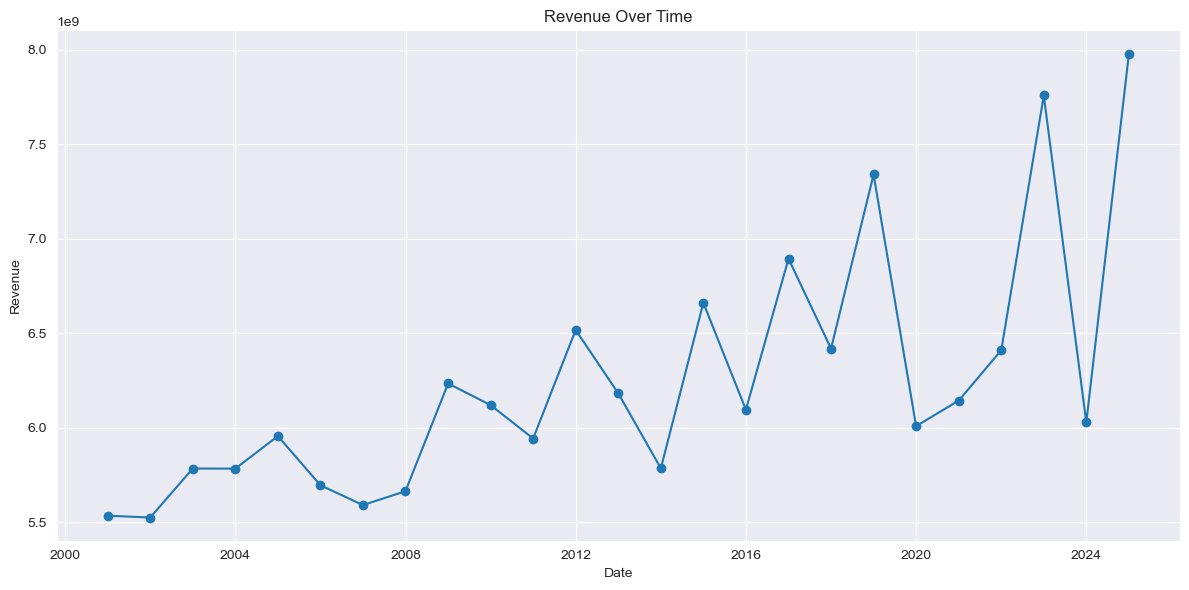

In [6]:
import matplotlib.pyplot as plt

# Convert FullDate to datetime and set as index
df_Revenue['FullDate'] = pd.to_datetime(df_Revenue['FullDate'])
df_Revenue.set_index('FullDate', inplace=True)

# Visualize
plt.figure(figsize=(12,6))
plt.plot(df_Revenue.index, df_Revenue['AF_Revenu'], marker='o')
plt.title('Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 4 : Marima

C:\Users\eya gadhoumi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\eya gadhoumi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\eya gadhoumi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eya gadhoumi\AppData\Local\Temp\ipykernel_18916\3228993893.py:29: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start=marima_data.index[-1] + pd.DateOffset(years=1), periods=steps, freq='Y')


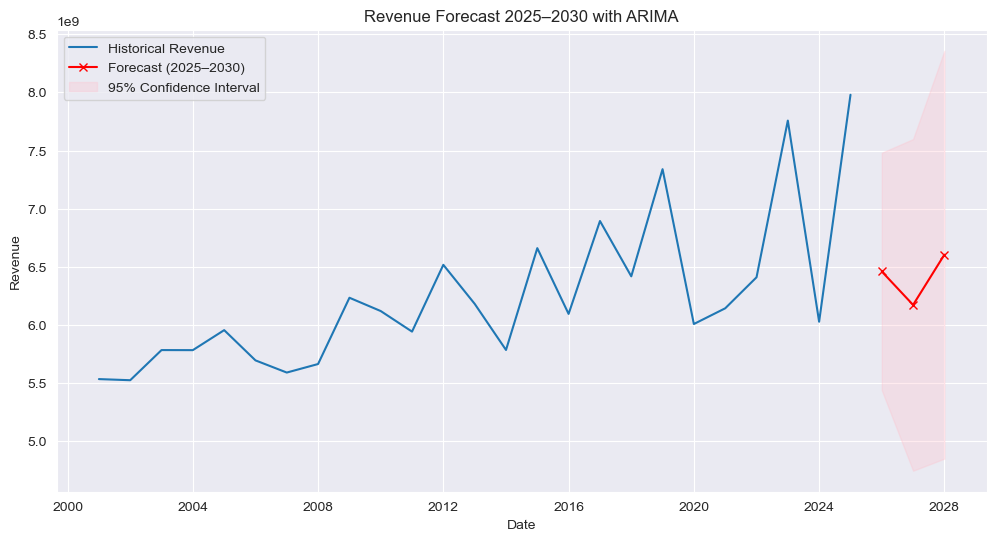


Forecast for 2025–2030:
   Year  Predicted_Revenue      Lower_CI      Upper_CI
0  2025       6.459960e+09  5.438955e+09  7.480965e+09
1  2026       6.172630e+09  4.746956e+09  7.598304e+09
2  2027       6.604538e+09  4.850971e+09  8.358106e+09


In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Assurer que l’index est au format datetime
marima_data = df_Revenue.copy()
marima_data.index = pd.to_datetime(marima_data.index)

# Utiliser les 24 premières années comme entraînement (jusqu'à 2024)
marima_train = marima_data.iloc[:24]  # 2001–2024

# Créer et ajuster le modèle ARIMA
marima_model = SARIMAX(
    marima_train['AF_Revenu'],
    order=(1, 1, 1),  # Tu peux ajuster ces paramètres si nécessaire
    trend='c'
)
marima_results = marima_model.fit(disp=False)

# Faire la prévision pour 5 ans (2025–2030)
steps = 3  # Attention : 2025 à 2030 inclus = 6 années
marima_forecast = marima_results.get_forecast(steps=steps)
marima_pred = marima_forecast.predicted_mean
marima_conf_int = marima_forecast.conf_int()

# Créer un index temporel pour les prévisions
future_years = pd.date_range(start=marima_data.index[-1] + pd.DateOffset(years=1), periods=steps, freq='Y')

# Tracer la prévision
plt.figure(figsize=(12, 6))
plt.plot(marima_data.index, marima_data['AF_Revenu'], label='Historical Revenue')
plt.plot(future_years, marima_pred, color='red', label='Forecast (2025–2030)', marker='x')
plt.fill_between(future_years,
                 marima_conf_int.iloc[:, 0],
                 marima_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('Revenue Forecast 2025–2030 with ARIMA')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

# Afficher les prévisions
forecast_df = pd.DataFrame({
    'Year': future_years.year,
    'Predicted_Revenue': marima_pred.values,
    'Lower_CI': marima_conf_int.iloc[:, 0].values,
    'Upper_CI': marima_conf_int.iloc[:, 1].values
})

print("\nForecast for 2025–2030:")
print(forecast_df)


# HERE !!!!!

C:\Users\eya gadhoumi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\eya gadhoumi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\eya gadhoumi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eya gadhoumi\AppData\Local\Temp\ipykernel_18916\728518236.py:29: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=n_forecast_years, freq='Y')


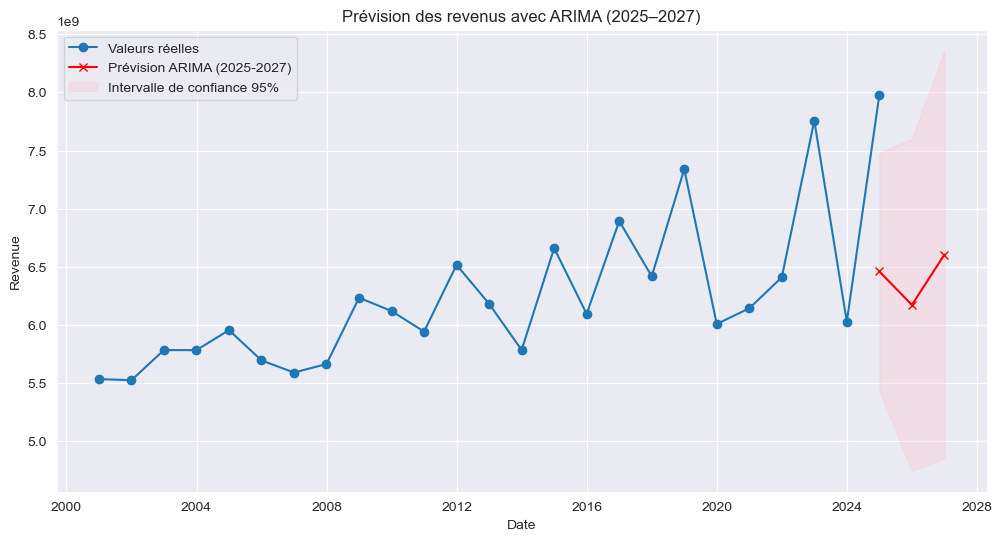


Prévision ARIMA pour 2025–2027 :
   Année     Prévision  Borne_inf_95  Borne_sup_95
0   2024  6.459960e+09  5.438955e+09  7.480965e+09
1   2025  6.172630e+09  4.746956e+09  7.598304e+09
2   2026  6.604538e+09  4.850971e+09  8.358106e+09


In [11]:
from pmdarima import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# Préparer les données
marima_data = df_Revenue.copy()
marima_data.index = pd.to_datetime(marima_data.index)

# Split : 24 premières années comme données d'entraînement
marima_train = marima_data.iloc[:24]  # 2000-2023 inclus
n_forecast_years = 3  # 2025, 2026, 2027

# Créer et ajuster le modèle ARIMA
marima_model = SARIMAX(marima_train['AF_Revenu'],
                       order=(1, 1, 1),
                       trend='c')
marima_results = marima_model.fit(disp=False)

# Générer les prévisions pour les 3 années suivantes
marima_forecast = marima_results.get_forecast(steps=n_forecast_years)
marima_pred = marima_forecast.predicted_mean
marima_conf_int = marima_forecast.conf_int()

# Générer les dates correspondantes pour les 3 années futures
last_date = marima_train.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=n_forecast_years, freq='Y')

# Tracer l'ensemble (entraînement + prévisions)
plt.figure(figsize=(12,6))
plt.plot(marima_data.index, marima_data['AF_Revenu'], label='Valeurs réelles', marker='o')
plt.plot(forecast_index, marima_pred, color='red', label='Prévision ARIMA (2025-2027)', marker='x')
plt.fill_between(forecast_index,
                 marima_conf_int.iloc[:, 0],
                 marima_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Intervalle de confiance 95%')
plt.title('Prévision des revenus avec ARIMA (2025–2027)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

# Affichage des résultats
forecast_table = pd.DataFrame({
    'Année': forecast_index.year,
    'Prévision': marima_pred.values,
    'Borne_inf_95': marima_conf_int.iloc[:, 0].values,
    'Borne_sup_95': marima_conf_int.iloc[:, 1].values
})

print("\nPrévision ARIMA pour 2025–2027 :")
print(forecast_table.round(2))


# save the model

In [12]:
import joblib

# Save the SARIMAX model
joblib.dump(marima_results, 'arima_revenue_model.pkl')


['arima_revenue_model.pkl']

# powerBI code

In [ ]:
import joblib
import pandas as pd

# Load the trained ARIMA model
model_path = r'C:/Users/YourName/Documents/PowerBI_Models/arima_revenue_model.pkl'
arima_model = joblib.load(model_path)

# Generate future forecast (e.g., 3 years ahead)
n_forecast_years = 3
forecast = arima_model.get_forecast(steps=n_forecast_years)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Generate datetime index for forecast (adjust according to your training data's last date)
forecast_index = pd.date_range(start='2025-12-31', periods=n_forecast_years, freq='Y')

# Create a dataframe for Power BI
forecast_df = pd.DataFrame({
    'Année': forecast_index.year,
    'Prévision': forecast_mean.values,
    'Borne_inf_95': forecast_conf_int.iloc[:, 0].values,
    'Borne_sup_95': forecast_conf_int.iloc[:, 1].values
})

# Output for Power BI
forecast_df
